In [ ]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

In [ ]:
import pickle
import torch.nn as nn
import torchvision
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Networks in PyTorch can be defined as in the example below:

In [ ]:
class ExampleNet(nn.Module):
    def __init__(self):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.fc_out = nn.Linear(128,400)

    def forward(self, x):
        c1 = self.conv1(x)
        bn1 = self.batchnorm1(c1)
        a1 = nn.functional.relu(bn1)
        p1 = self.pool1(a1)

        c2 = self.conv2(p1)
        bn2 = self.batchnorm2(c2)
        a2 = nn.functional.relu(bn2)
        p2 = self.pool2(a2)

        c3 = self.conv3(p2)
        bn3 = self.batchnorm3(c3)
        a3 = nn.functional.relu(bn3)
        p3 = self.pool3(a3)

        c4 = self.conv4(p3)
        bn4 = self.batchnorm4(c4)
        a4 = nn.functional.relu(bn4)
        # Take the global average of each channel
        global_avg = torch.mean(a4, dim=[2,3])
        out = self.fc_out(global_avg)
        return out

# Loading the data

We will use a bird dataset, where the task is to classify each image into one of 400 different classes of birds.

## Data Loader

* PyTorch typically uses Dataset and DataLoader classes to load data during training. The DataLoader enables processing data on multiple cores (num_workers argument), which is useful as the data loading speed is commonly the bottleneck in network training.

* The batch size used during training is also usually an argument of the DataLoader. 

* We will be using the torchvision.datasets.ImageFolder class that can easily load images that have been separated into individual folders by class. The data loader then outputs the data in the form of (image, label) pairs. For tasks other than classification, custom dataset classes are more common.

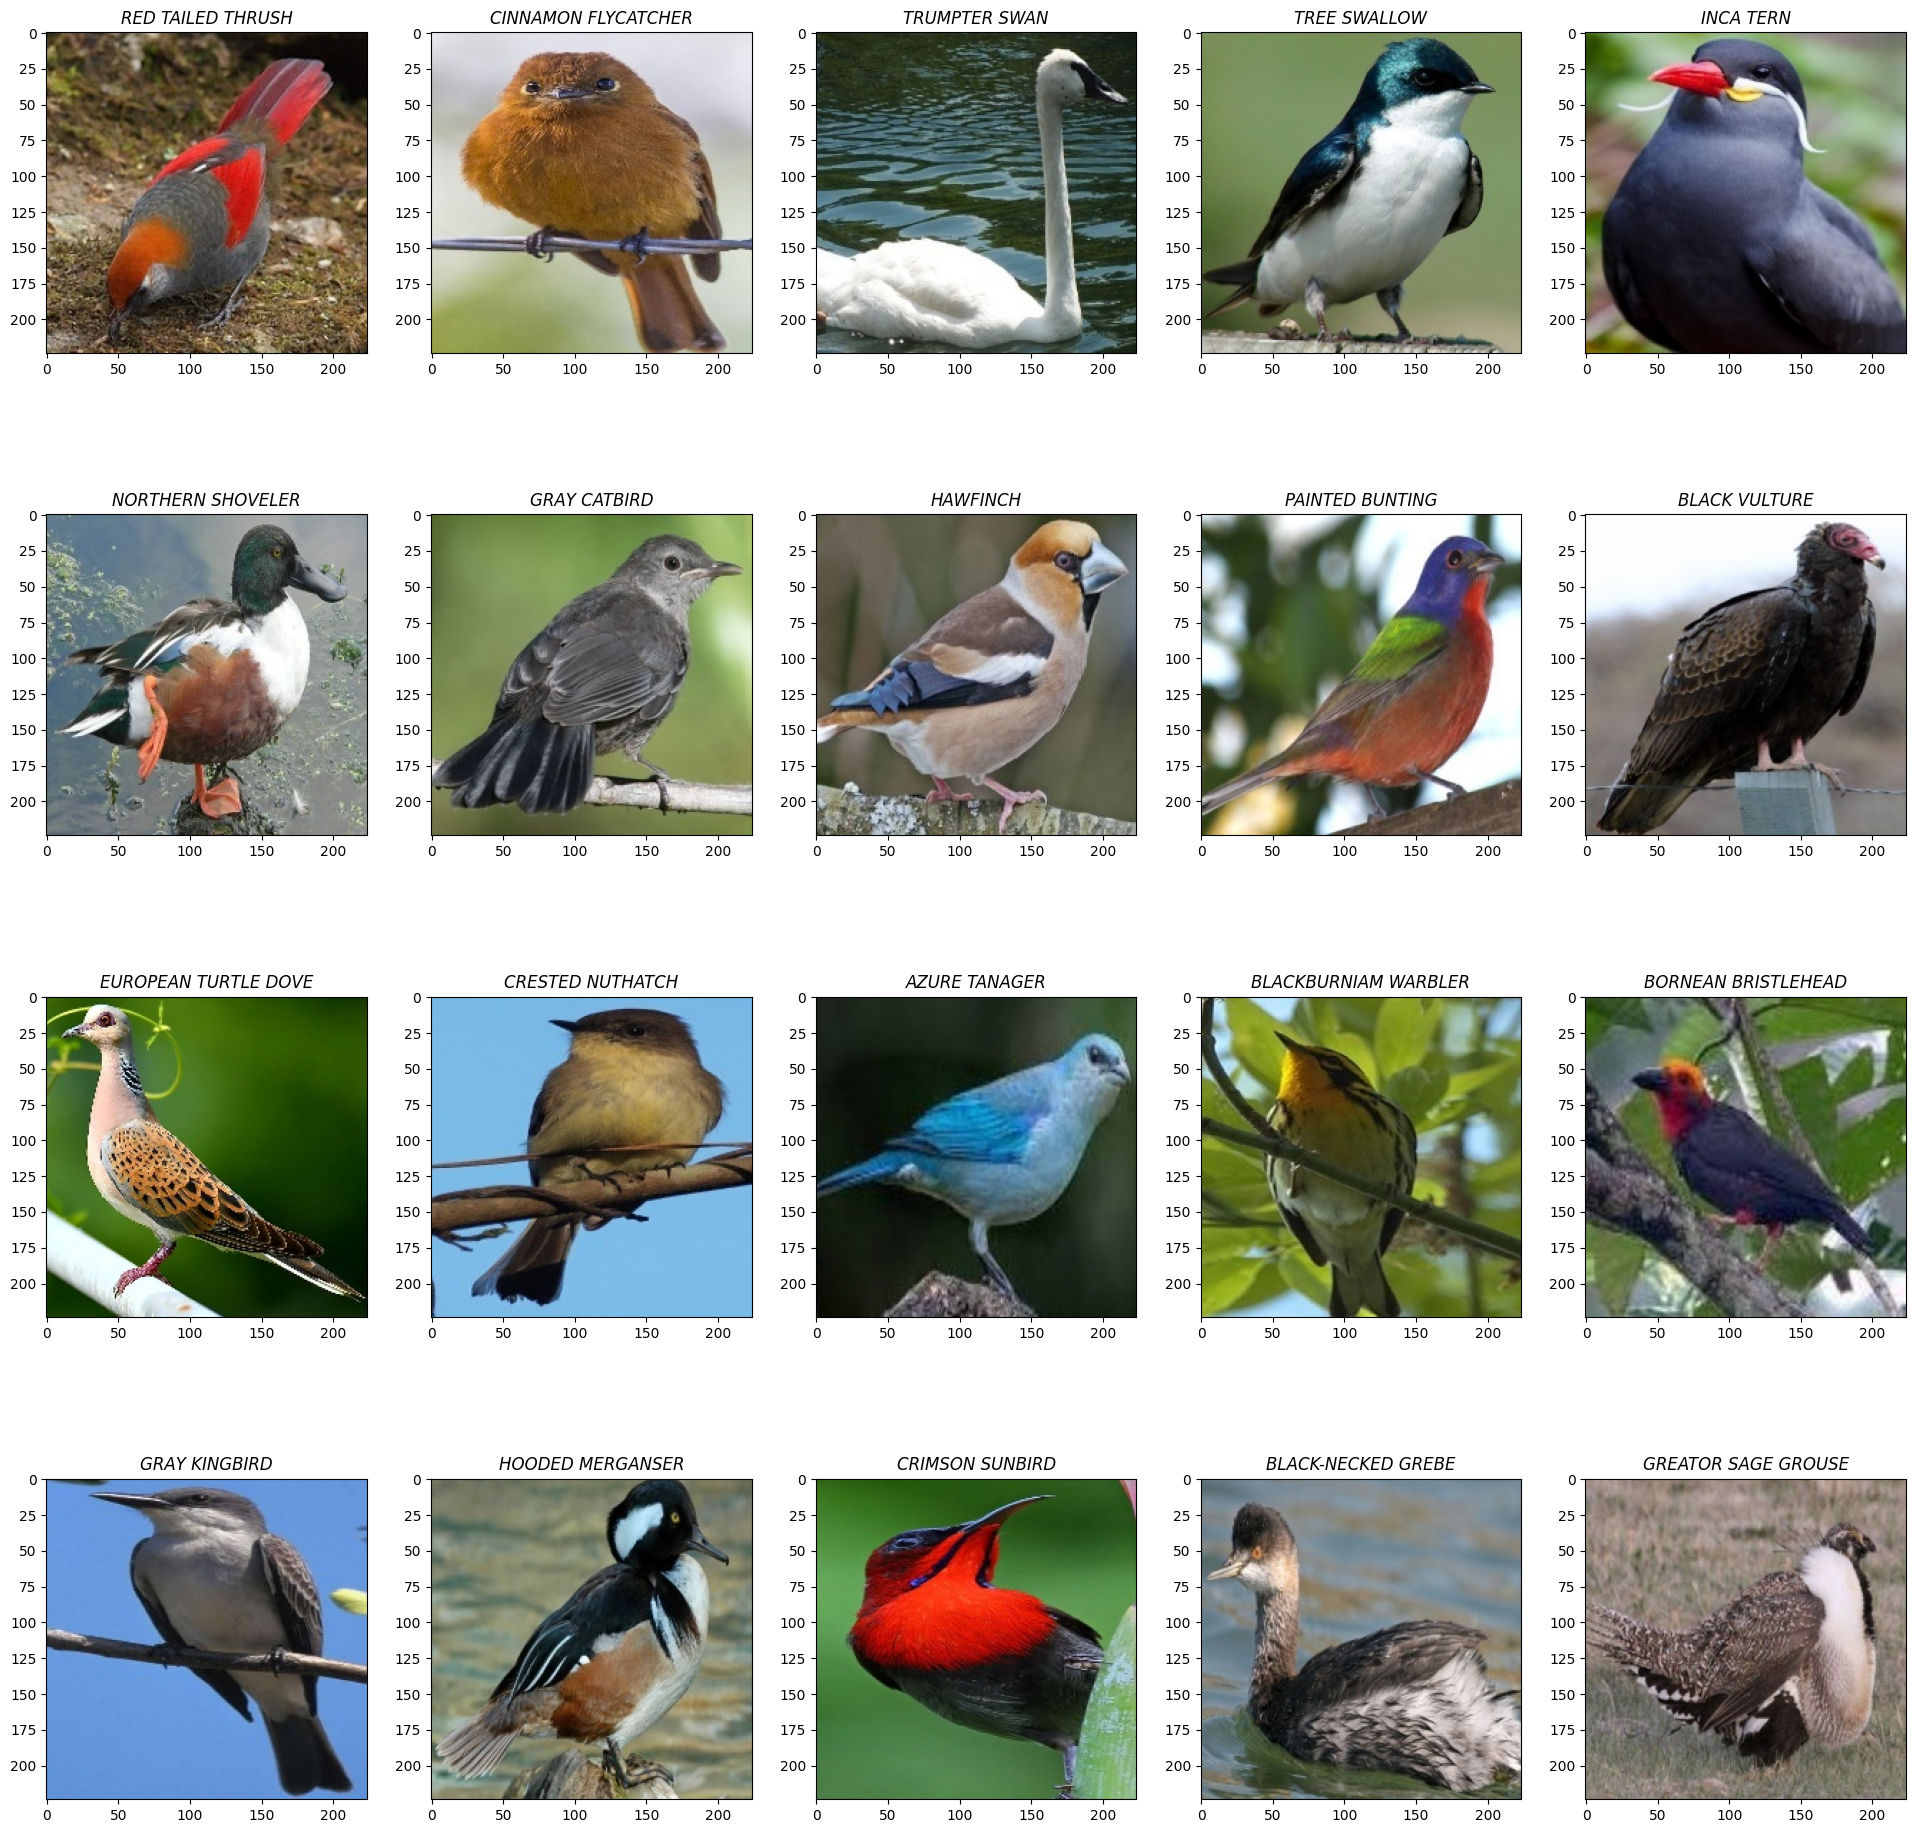

In [ ]:
batch_size = 32
# Transforms can also be used for image augmentation - https://pytorch.org/vision/stable/transforms.html
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    ])


trainset = torchvision.datasets.ImageFolder(root='./data/bird_data/train/',transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./data/bird_data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root='./data/bird_data/valid/',transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


# Displaying random trainset images
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(columns*rows):
  input, label = trainset[np.random.randint(len(trainset))]
  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title(trainset.classes[label], fontstyle='italic')
  plt.imshow(img)
plt.show()



## Training the network

The training parameters (learning rate, batch size, optimizer choice etc.) are not fine-tuned. Feel free to optimize the parameters further to improve the results. 

In [ ]:
def test_bird_model(net, curr_data_loader, val_test="val"):
    # Testing

    criterion = nn.CrossEntropyLoss()

    num_images = len(curr_data_loader.dataset)
    gt_array = np.zeros(num_images)
    pred_array = np.zeros(num_images)

    correct = 0
    total = 0
    running_loss = 0.0
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(curr_data_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            gt_array[i*labels.size(0):(i+1)*labels.size(0)] = labels.detach().cpu().numpy()
            pred_array[i*labels.size(0):(i+1)*labels.size(0)] = predicted.detach().cpu().numpy()

    print('Accuracy of the network on %s images: %d %%' % (val_test,
            100 * correct / total))
    print("Test loss: "+str(running_loss/(total/4)))
    return gt_array, pred_array

def train_bird_model(epochs, lr):
    # Use the ResNet18 when implemented
    #net = ResNet18()
    net = ExampleNet()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # Get the inputs; Data is a tuple of (images, labels)
                inputs, labels = data
                # Transfer the images and labels to the GPU.
                inputs = inputs.cuda()
                labels = labels.cuda()

                # Clear the saved gradients of the previous iteration
                optimizer.zero_grad()

                outputs = net(inputs)
                # Calculate the loss value
                loss = criterion(outputs, labels)
                # Calculate the gradients using backpropagation
                loss.backward()
                # Update the weights of the network using the chosen optimizer
                optimizer.step()

                prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
                prog_bar.update(batch_size)
        
        if epoch % 5 == 0:
            test_bird_model(net, valloader)
    test_bird_model(net,testloader)

    return net
        



## Run training

In [ ]:
net = train_bird_model(10,0.001)

Epoch: 0/10:   0%|          | 0/58388 [00:04<?, ?img/s]


KeyboardInterrupt: 

## Run Test and visualize classification errors



Accuracy of the network on val images: 73 %
Test loss: 0.13375419226288796


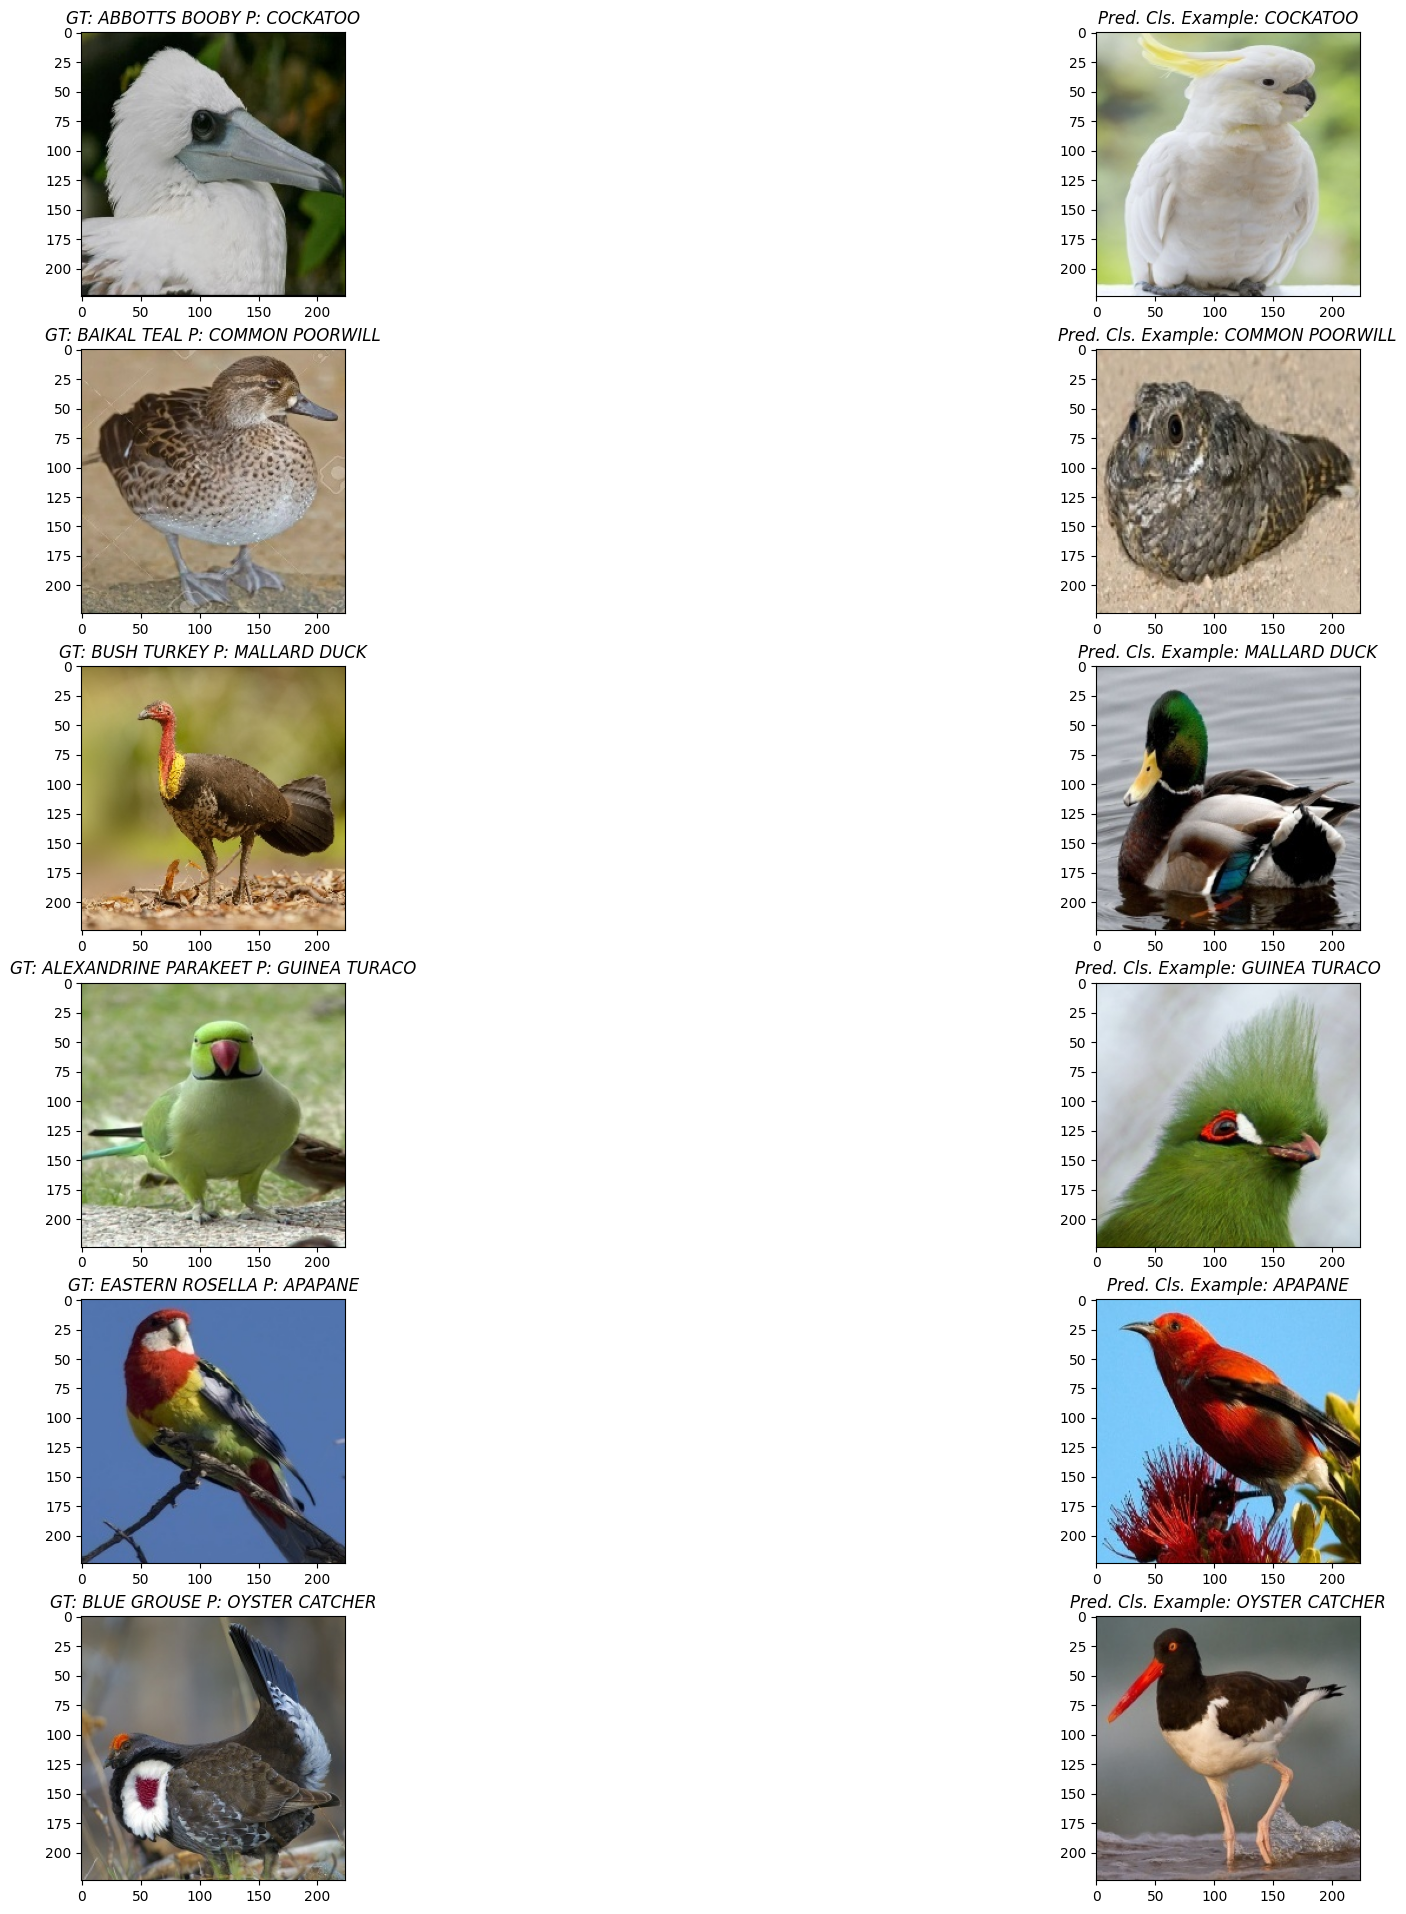

In [ ]:
gt_array, pred_array = test_bird_model(net,testloader)

# Displaying random misclassified images
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 6
mistake_indices = np.nonzero(gt_array != pred_array)[0]
for i in range(rows):
  chosen_index = mistake_indices[np.random.randint(len(mistake_indices))]
  input, label = testset[chosen_index]
  pred_label = pred_array[chosen_index].astype(np.int32)
  pred_cls_samples = np.nonzero(gt_array == pred_label)[0]
  pred_cls_input, _ = testset[pred_cls_samples[np.random.randint(len(pred_cls_samples))]]


  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+1)
  im_title = "GT: "+trainset.classes[label] + " P: "+trainset.classes[pred_label] 
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img)

  img_sample = pred_cls_input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+2)
  im_title = "Pred. Cls. Example: "+trainset.classes[pred_label] 
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img_sample)

plt.show()
